<a href="https://colab.research.google.com/github/aryan2107-cloud/100-Day-ML-Challenge-/blob/main/Day27_DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, adjusted_rand_score

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

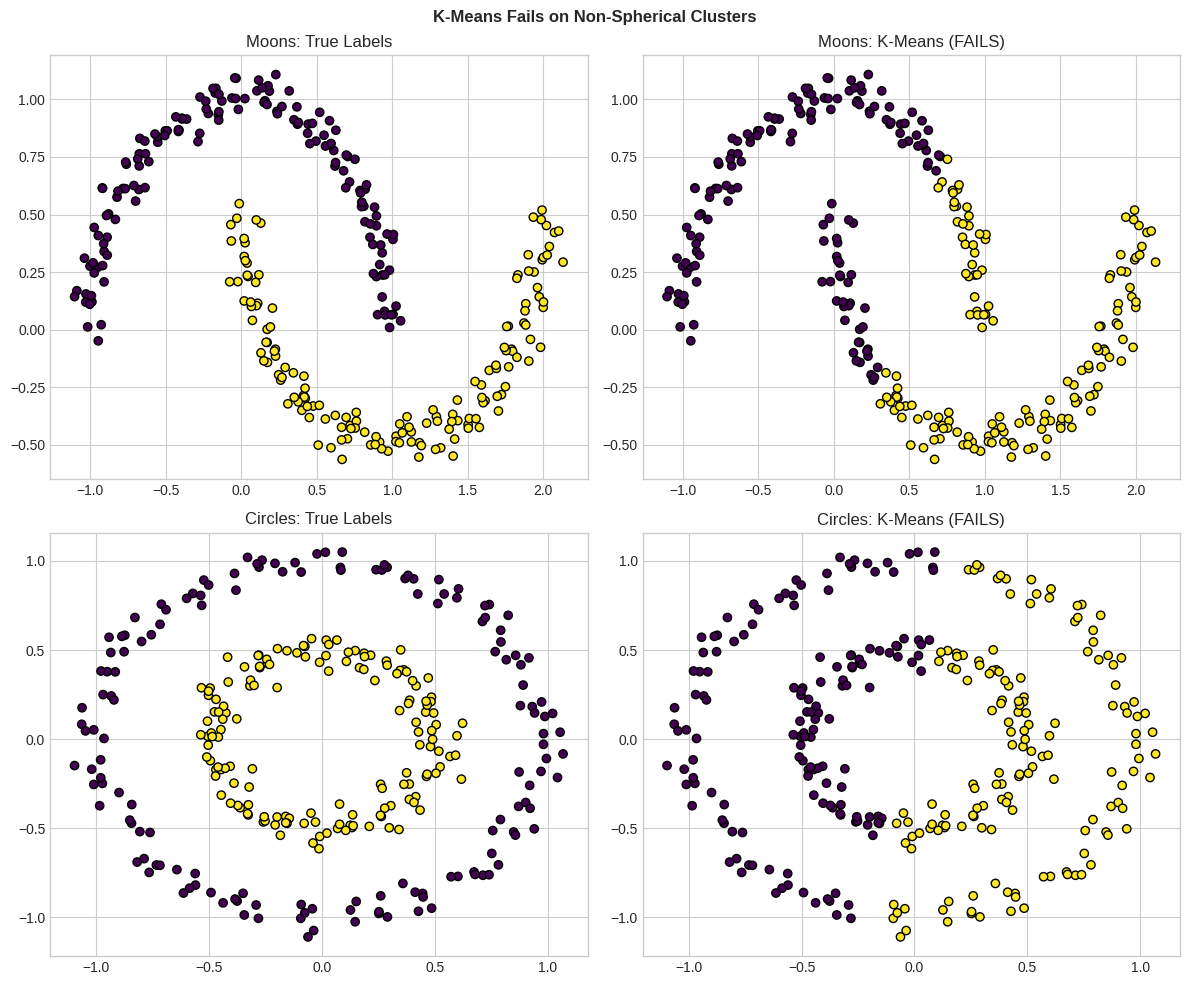

In [5]:
# K-Means assumes spherical clusters — fails on complex shapes
x_moons, y_moons = make_moons(n_samples=300, noise=0.05, random_state=42)
x_circles, y_circles = make_circles(n_samples=300, noise=0.05, factor=0.5, random_state=42)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Moons
axes[0, 0].scatter(x_moons[:, 0], x_moons[:, 1], c=y_moons, cmap='viridis', edgecolor='black')
axes[0, 0].set_title('Moons: True Labels')

kmeans_moons = KMeans(n_clusters=2, random_state=42)
axes[0, 1].scatter(x_moons[:, 0], x_moons[:, 1], c=kmeans_moons.fit_predict(X_moons),
                   cmap='viridis', edgecolor='black')
axes[0, 1].set_title('Moons: K-Means (FAILS)')

# Circles
axes[1, 0].scatter(x_circles[:, 0], x_circles[:, 1], c=y_circles, cmap='viridis', edgecolor='black')
axes[1, 0].set_title('Circles: True Labels')

kmeans_circles = KMeans(n_clusters=2, random_state=42)
axes[1, 1].scatter(x_circles[:, 0], x_circles[:, 1], c=kmeans_circles.fit_predict(X_circles),
                   cmap='viridis', edgecolor='black')
axes[1, 1].set_title('Circles: K-Means (FAILS)')

plt.suptitle('K-Means Fails on Non-Spherical Clusters', fontweight='bold')
plt.tight_layout()
plt.show()


##How DBSCAN Works

**DBSCAN = Density-Based Spatial Clustering of Applications with Noise**

**Key idea:** Clusters are dense regions separated by sparse regions

**Parameters:**
- `eps`: Neighborhood radius
- `min_samples`: Minimum points to form a dense region

**Point types:**
- **Core point:** Has >= min_samples within eps
- **Border point:** Within eps of a core point, but not core itself
- **Noise point:** Neither core nor border (outlier)

DBSCAN on Moons

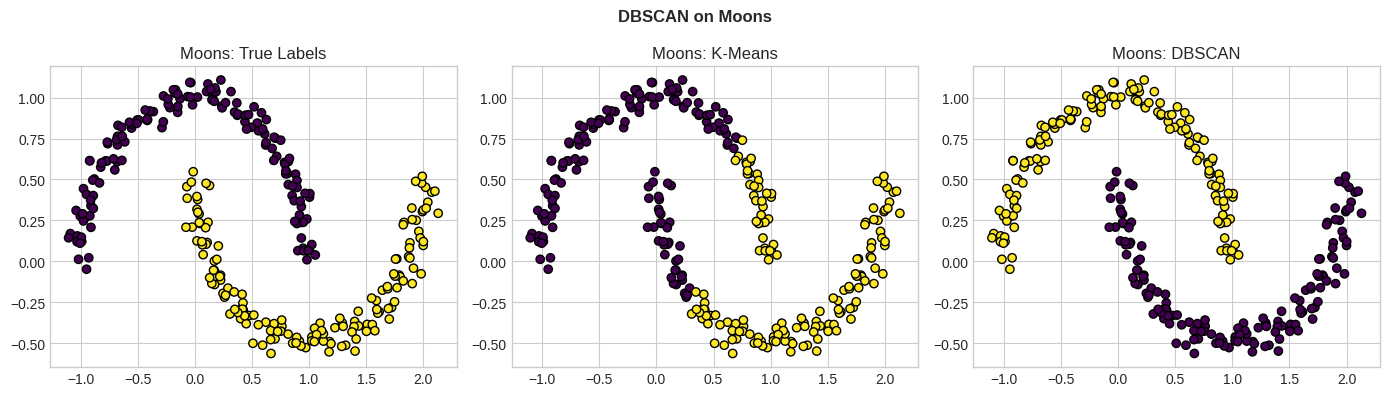

DBSACN found 2 clusters
Noise points: 0


In [7]:
dbscan_moons = DBSCAN(eps=0.2, min_samples=5)
labels_moons = dbscan_moons.fit_predict(x_moons)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].scatter(x_moons[:, 0], x_moons[:, 1], c=y_moons, cmap='viridis', edgecolor='black')
axes[0].set_title('Moons: True Labels')

axes[1].scatter(x_moons[:, 0], x_moons[:, 1], c=kmeans_moons.fit_predict(x_moons), cmap='viridis', edgecolor='black')
axes[1].set_title('Moons: K-Means')

axes[2].scatter(x_moons[:, 0], x_moons[:, 1], c=labels_moons, cmap='viridis', edgecolor='black')
axes[2].set_title('Moons: DBSCAN')

plt.suptitle('DBSCAN on Moons', fontweight='bold')
plt.tight_layout()
plt.show()

print(f"DBSACN found {len(set(labels_moons)) - (1 if -1 in labels_moons else 0)} clusters")
print(f"Noise points: {list(labels_moons).count(-1)}")

DBSCAN on circles

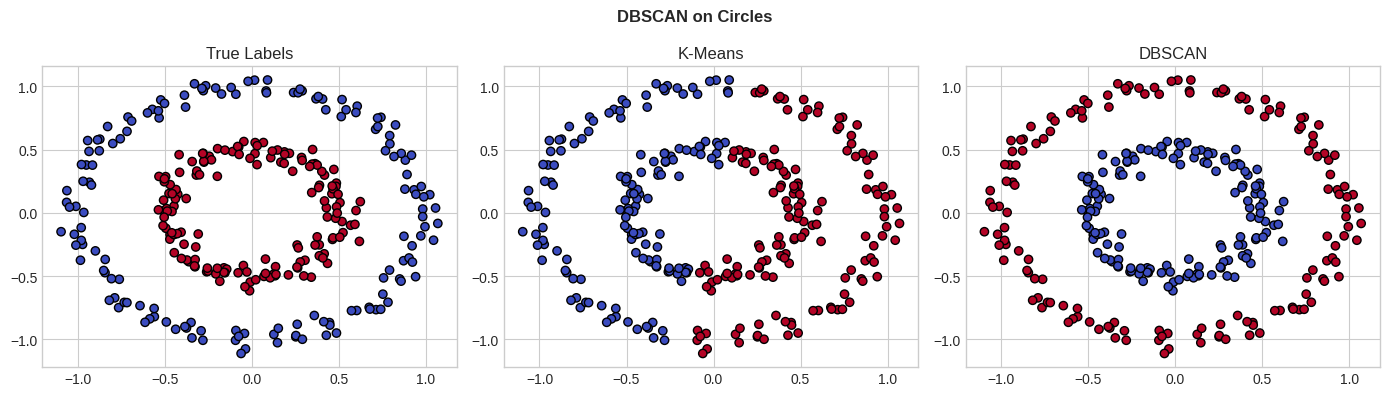

In [11]:
dbscan_circles = DBSCAN(eps=0.2, min_samples=5)
labels_circles = dbscan_circles.fit_predict(x_circles)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].scatter(x_circles[:, 0], x_circles[:, 1], c=y_circles, cmap='coolwarm', edgecolor='black')
axes[0].set_title("True Labels")

axes[1].scatter(x_circles[:, 0], x_circles[:, 1], c=kmeans_circles.fit_predict(x_circles), cmap='coolwarm', edgecolor='black')
axes[1].set_title("K-Means")

axes[2].scatter(x_circles[:, 0], x_circles[:, 1], c=labels_circles, cmap='coolwarm', edgecolor='black')
axes[2].set_title("DBSCAN")

plt.suptitle("DBSCAN on Circles", fontweight='bold')
plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

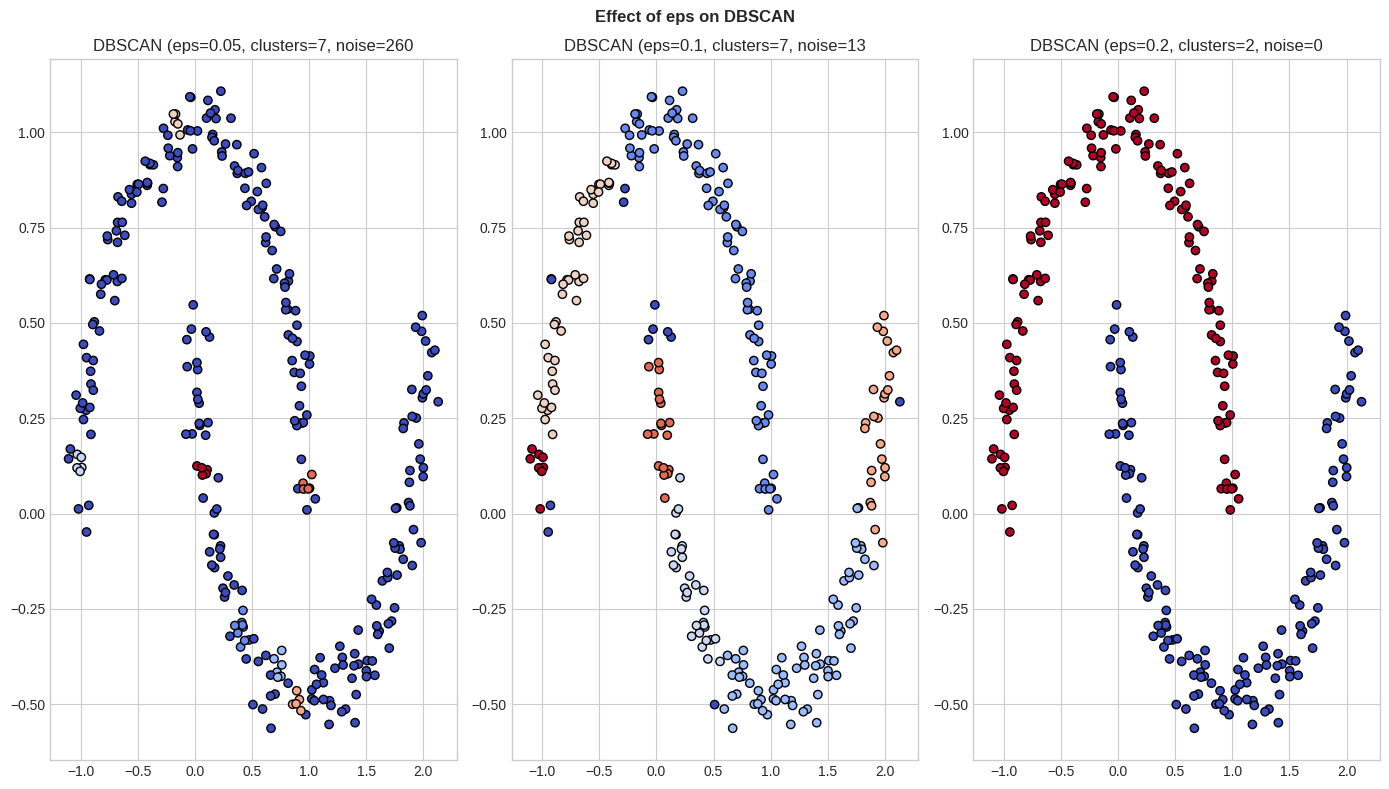

In [12]:
#Effect of the eps parameter
eps_values = [0.05, 0.1, 0.2, 0.3, 0.5, 1.0]

fig, axes = plt.subplots(1, 3, figsize=(14, 8))
axes = axes.flatten()

for ax, eps in zip(axes, eps_values):
  dbscan = DBSCAN(eps=eps, min_samples=5)
  labels = dbscan.fit_predict(x_moons)
  n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise = (labels == -1).sum()

  ax.scatter(x_moons[:, 0], x_moons[:, 1], c=labels, cmap='coolwarm', edgecolor='black')
  ax.set_title(f'DBSCAN (eps={eps}, clusters={n_clusters}, noise={n_noise}')

plt.suptitle('Effect of eps on DBSCAN', fontweight='bold')
plt.tight_layout()
plt.show

Finding optimal eps (K-Distance plot)

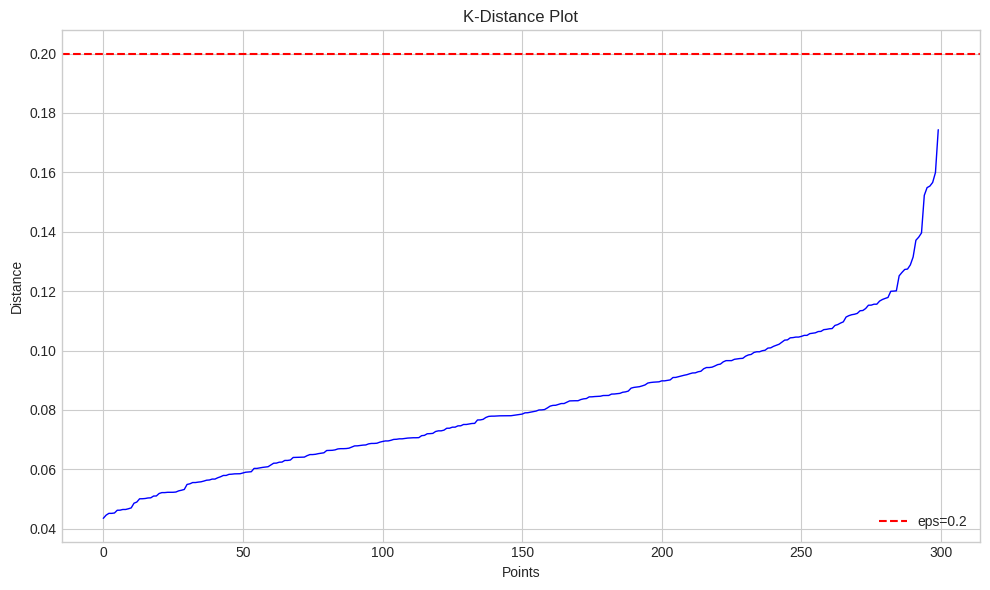

In [17]:
# K-distance plot: sort distances to k-th nearest neighbor
# Look for "elbow" = natural eps value

def k_distance_plot(x, k=5):
  neighbors = NearestNeighbors(n_neighbors=k)
  neighbors.fit(x)
  distances, _ = neighbors.kneighbors(x)

  #Get distance to the k=th neighbor (last Column)
  k_distances = distances[:, -1]
  k_distances = np.sort(k_distances)

  return k_distances

k_dist = k_distance_plot(x_moons, k=5)

plt.figure(figsize=(10, 6))
plt.plot(k_dist, 'b-', linewidth=1)
plt.axhline(y=0.2, color='red', linestyle='--', label='eps=0.2')
plt.xlabel('Points')
plt.ylabel('Distance')
plt.title('K-Distance Plot')
plt.legend()
plt.tight_layout()
plt.show()



How DBSCAN outliers

<function matplotlib.pyplot.show(close=None, block=None)>

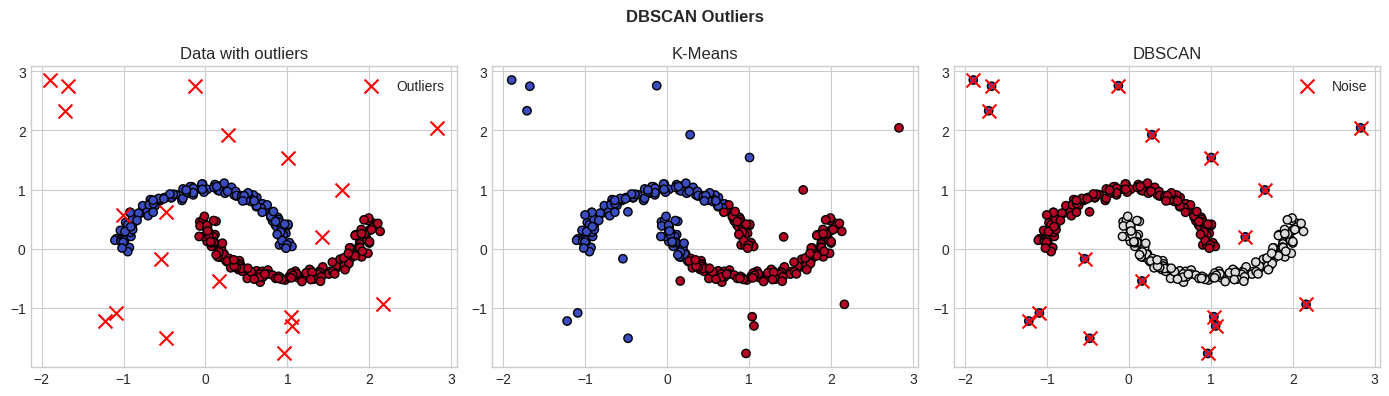

In [22]:
#Add outliers to moons
np.random.seed(42)
outliers = np.random.uniform(-2, 3, (20, 2))
x_moons_noisy = np.vstack([x_moons, outliers])
y_moons_noisy = np.hstack([y_moons, [-1] * 20])

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

#True labels
axes[0].scatter(x_moons[:, 0], x_moons[:, 1], c=y_moons, cmap='coolwarm', edgecolor='black')
axes[0].scatter(outliers[:, 0], outliers[:, 1], c='red', marker='x', s=100, label='Outliers')
axes[0].legend()
axes[0].set_title('Data with outliers')

#K-Means
km_noisy = KMeans(n_clusters, random_state=42)
axes[1].scatter(x_moons_noisy[:, 0], x_moons_noisy[:, 1], c=km_noisy.fit_predict(x_moons_noisy), cmap='coolwarm', edgecolor='black')
axes[1].set_title('K-Means')

# DBSCAN
db_noisy = DBSCAN(eps=0.2, min_samples=5)
labels_noisy = db_noisy.fit_predict(x_moons_noisy)
axes[2].scatter(x_moons_noisy[:, 0], x_moons_noisy[:, 1], c=labels_noisy, cmap='coolwarm', edgecolor='black')
axes[2].scatter(x_moons_noisy[labels_noisy == -1, 0], x_moons_noisy[labels_noisy == -1, 1], c='red', marker='x', s=100, label='Noise')
axes[2].legend()
axes[2].set_title('DBSCAN')

plt.suptitle('DBSCAN Outliers', fontweight='bold')
plt.tight_layout()
plt.show

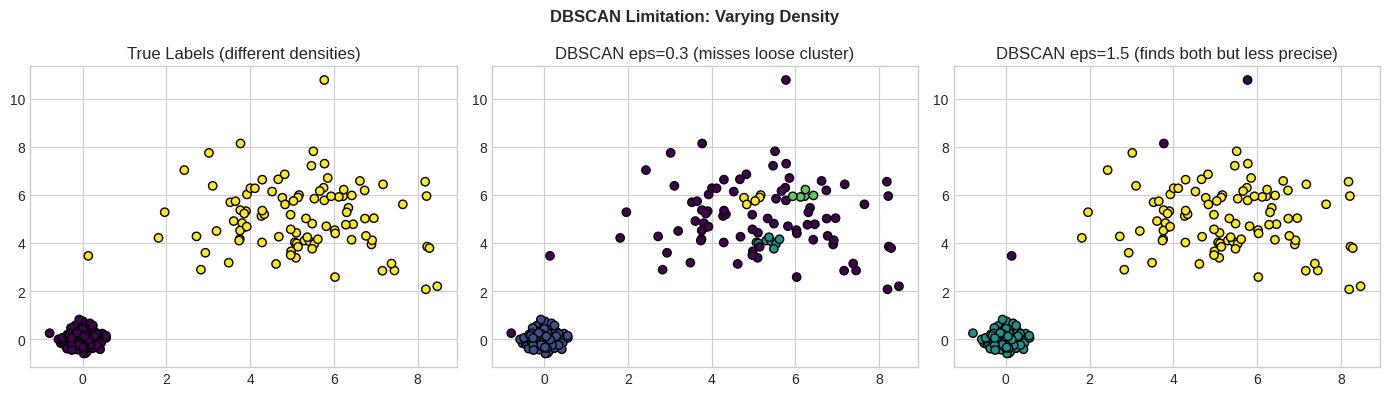

DBSCAN struggles when clusters have very different densities
Solution: HDBSCAN (Hierarchical DBSCAN)


In [23]:
# DBSCAN's weakness: varying density clusters
np.random.seed(42)
X_varied = np.vstack([
    np.random.randn(100, 2) * 0.3 + [0, 0],      # tight cluster
    np.random.randn(100, 2) * 1.5 + [5, 5]       # loose cluster
])
y_varied = np.array([0]*100 + [1]*100)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].scatter(X_varied[:, 0], X_varied[:, 1], c=y_varied, cmap='viridis', edgecolor='black')
axes[0].set_title('True Labels (different densities)')

# Small eps
db_small = DBSCAN(eps=0.3, min_samples=5)
axes[1].scatter(X_varied[:, 0], X_varied[:, 1], c=db_small.fit_predict(X_varied),
                cmap='viridis', edgecolor='black')
axes[1].set_title('DBSCAN eps=0.3 (misses loose cluster)')

# Large eps
db_large = DBSCAN(eps=1.5, min_samples=5)
axes[2].scatter(X_varied[:, 0], X_varied[:, 1], c=db_large.fit_predict(X_varied),
                cmap='viridis', edgecolor='black')
axes[2].set_title('DBSCAN eps=1.5 (finds both but less precise)')

plt.suptitle('DBSCAN Limitation: Varying Density', fontweight='bold')
plt.tight_layout()
plt.show()

print("DBSCAN struggles when clusters have very different densities")
print("Solution: HDBSCAN (Hierarchical DBSCAN)")

In [26]:
#Quantitative using adjusted Rand Index
datasets = {
    'Moons': (x_moons, y_moons),
    'Circles': (x_circles, y_circles)
}

print(f"{'Dataset':<12} {'K-Means ARI':<15} {'DBSCAN ARI':<15}")

for name, (x, y) in datasets.items():
  km_labels = KMeans(n_clusters=2, random_state=42).fit_predict(x)
  db_labels = DBSCAN(eps=0.2, min_samples=5).fit_predict(x)

  km_ari = adjusted_rand_score(y, km_labels)
  db_ari = adjusted_rand_score(y, db_labels)

  print(f"{name:<12} {km_ari:<15.4f} {db_ari:<15.4f}")

print("\nARI = 1.0 is perfect, 0.0  is random")

Dataset      K-Means ARI     DBSCAN ARI     
Moons        0.2475          1.0000         
Circles      -0.0034         1.0000         

ARI = 1.0 is perfect, 0.0  is random


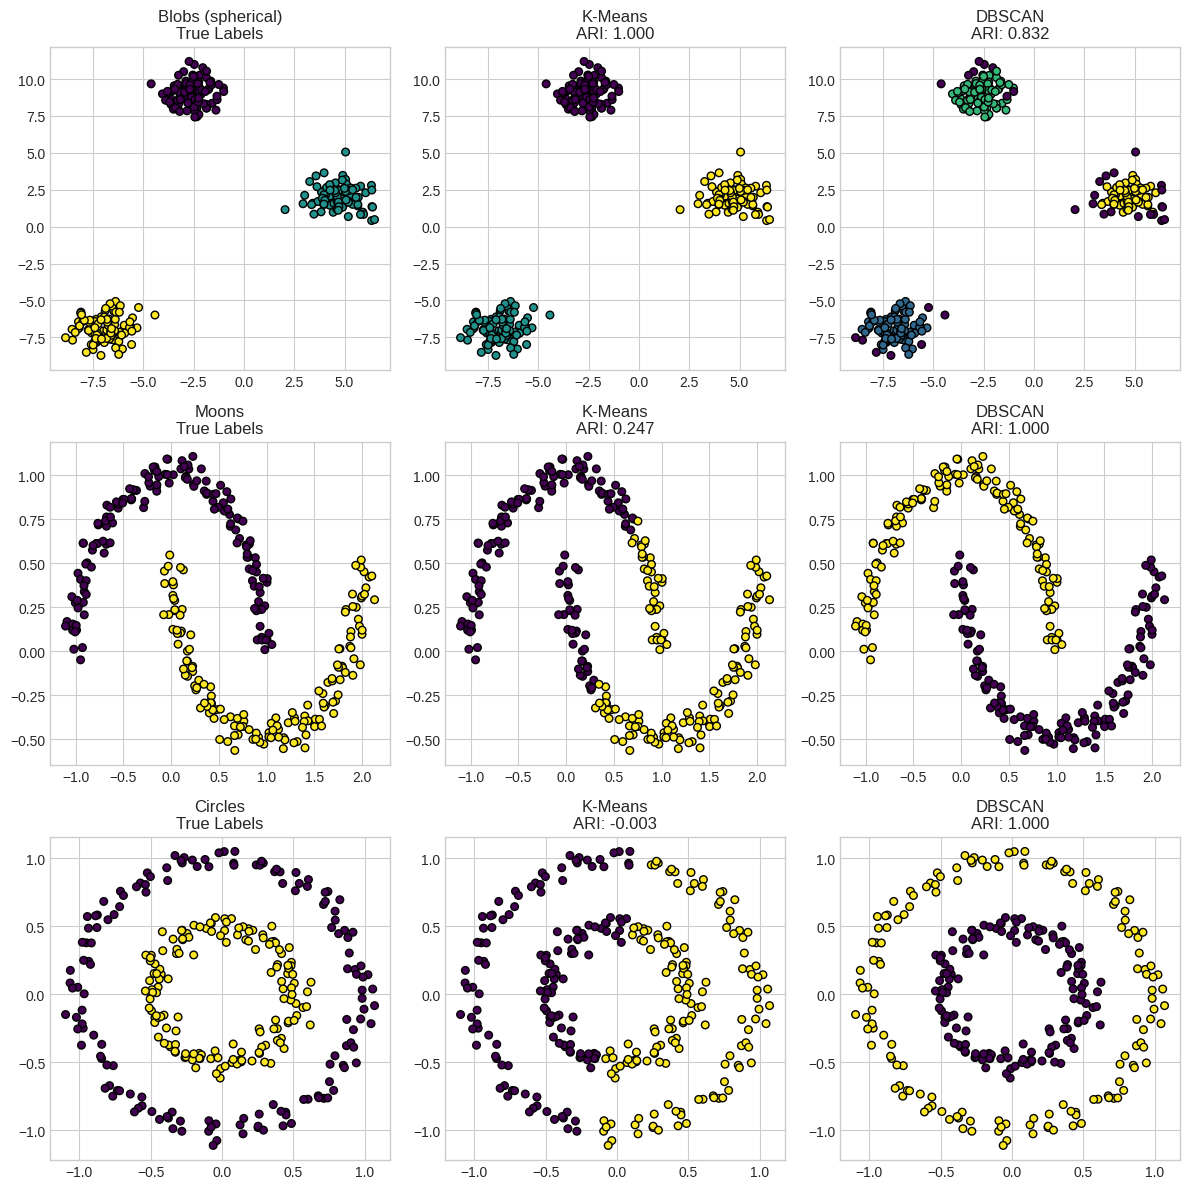

In [27]:
# Final comparison on all shapes
X_blobs, y_blobs = make_blobs(n_samples=300, centers=3, cluster_std=0.8, random_state=42)

datasets = [
    ('Blobs (spherical)', X_blobs, y_blobs, 3, 0.5),
    ('Moons', X_moons, y_moons, 2, 0.2),
    ('Circles', X_circles, y_circles, 2, 0.2)
]

fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for row, (name, X, y, n_clusters, eps) in enumerate(datasets):
    # True
    axes[row, 0].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='black', s=30)
    axes[row, 0].set_title(f'{name}\nTrue Labels')

    # K-Means
    km = KMeans(n_clusters=n_clusters, random_state=42)
    axes[row, 1].scatter(X[:, 0], X[:, 1], c=km.fit_predict(X), cmap='viridis', edgecolor='black', s=30)
    axes[row, 1].set_title(f'K-Means\nARI: {adjusted_rand_score(y, km.labels_):.3f}')

    # DBSCAN
    db = DBSCAN(eps=eps, min_samples=5)
    axes[row, 2].scatter(X[:, 0], X[:, 1], c=db.fit_predict(X), cmap='viridis', edgecolor='black', s=30)
    axes[row, 2].set_title(f'DBSCAN\nARI: {adjusted_rand_score(y, db.labels_):.3f}')

plt.tight_layout()
plt.show()

## Summary

### DBSCAN vs K-Means

| Aspect | K-Means | DBSCAN |
|--------|---------|--------|
| Cluster shape | Spherical only | Any shape |
| Number of clusters | Must specify K | Automatic |
| Outliers | Forces into clusters | Labels as noise |
| Parameters | K | eps, min_samples |
| Speed | Fast | Slower |
| Varying density | OK | Struggles |

### DBSCAN Parameters

| Parameter | Effect | How to Choose |
|-----------|--------|---------------|
| eps | Neighborhood radius | K-distance plot elbow |
| min_samples | Density threshold | Start with 2 x dimensions |

### When to Use DBSCAN

**Good for:**
- Non-spherical clusters
- Unknown number of clusters
- Data with outliers
- Spatial data

**Not ideal for:**
- Varying density clusters
- Very high dimensions
- When you need every point assigned

### Key Takeaways
1. DBSCAN finds clusters of any shape
2. No need to specify K upfront
3. Automatically identifies outliers as noise
4. Use k-distance plot to find eps
5. Always scale your features!